In [3]:
# Cell 1 — seeds + imports (run once)

import os, math, warnings
import numpy as np
import torch, gpytorch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.transforms import normalize, unnormalize
from botorch.exceptions import OptimizationWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=gpytorch.utils.warnings.NumericalWarning)
warnings.filterwarnings("ignore", category=OptimizationWarning)

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_global_seed(seed):
    import random
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    # deterministic-ish kernels
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Device:", device)


Device: cpu


In [4]:
# Cell 2 — SpeedReducerProblem (your exact version)

import numpy as np


class SpeedReducerProblem:
    def __init__(self, enforce_integer_teeth=True):
        self.enforce_integer_teeth = enforce_integer_teeth
        self.lb = np.array([2.6, 0.7, 17.0, 7.3, 7.3, 2.9, 5.0], dtype=np.float64)
        self.ub = np.array([3.6, 0.8, 28.0, 8.3, 8.3, 3.9, 5.5], dtype=np.float64)
        self.dim = 7
        self.n_constraints = 11
        self.f_star_ref = 2996.3482

    def coerce_shape(self, X):
        X = np.asarray(X, dtype=np.float64)
        was_1d = (X.ndim == 1)
        if was_1d: X = X[None, :]
        assert X.shape[-1] == 7, "Expected last dimension to be 7."
        return X, was_1d

    def project_to_bounds(self, X):
        return np.clip(X, self.lb, self.ub)

    def evaluate(self, X):
        X, was_1d = self.coerce_shape(X)
        X = self.project_to_bounds(X).copy()
        if self.enforce_integer_teeth:
            X[:, 2] = np.rint(X[:, 2])
        x1, x2, x3, x4, x5, x6, x7 = [X[:, i] for i in range(7)]
        f = (0.7854 * x1 * x2 ** 2 * (3.3333 * x3 ** 2 + 14.9334 * x3 - 43.0934)
             - 1.508 * x1 * (x6 ** 2 + x7 ** 2)
             + 7.4777 * (x6 ** 3 + x7 ** 3)
             + 0.7854 * (x4 * x6 ** 2 + x5 * x7 ** 2))
        g = np.empty((X.shape[0], 11), dtype=np.float64)
        g[:, 0] = 27.0 / (x1 * x2 ** 2 * x3) - 1.0
        g[:, 1] = 397.5 / (x1 * x2 ** 2 * x3 ** 2) - 1.0
        g[:, 2] = 1.93 * x4 ** 3 / (x2 * x3 * x6 ** 4) - 1.0
        g[:, 3] = 1.93 * x5 ** 3 / (x2 * x3 * x7 ** 4) - 1.0
        g[:, 4] = np.sqrt((745.0 * x4 / (x2 * x3)) ** 2 + 16.9e6) / (0.1 * x6 ** 3) - 1100.0
        g[:, 5] = np.sqrt((745.0 * x5 / (x2 * x3)) ** 2 + 157.5e6) / (0.1 * x7 ** 3) - 850.0
        g[:, 6] = x2 * x3 - 40.0
        g[:, 7] = 5.0 - x1 / x2
        g[:, 8] = x1 / x2 - 12.0
        g[:, 9] = 1.5 * x6 + 1.9 - x4
        g[:, 10] = 1.1 * x7 + 1.9 - x5
        if was_1d: return f[0], g[0]
        return f, g

    def is_feasible(self, X):
        _, g = self.evaluate(X)
        return np.all(g <= 0.0, axis=-1)

    def sample_lhs(self, n, rng=None):
        if rng is None: rng = np.random.default_rng()
        d = self.dim
        cut = np.linspace(0, 1, n + 1)
        a, b = cut[:-1], cut[1:]
        u = rng.random((n, d))
        pts = a[:, None] + (b - a)[:, None] * u
        X = np.empty_like(pts)
        for j in range(d):
            X[:, j] = pts[rng.permutation(n), j]
        X = self.lb + X * (self.ub - self.lb)
        if self.enforce_integer_teeth:
            X[:, 2] = np.rint(X[:, 2])
        return X


In [5]:
# Cell 3 — GPs + helpers (sturdy + on device)

def standardize(y_np):
    y_np = np.asarray(y_np, dtype=np.float64).reshape(-1, 1)
    mu = float(y_np.mean())
    sd = float(y_np.std() + 1e-12)
    y_std = (y_np - mu) / sd
    return y_std.ravel(), mu, sd


class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, X, y, likelihood):
        super().__init__(X, y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X.shape[-1])
        )

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)


def fit_gp(X_np, y_np, iters=100, lr=0.05):
    y_std, mu, sd = standardize(y_np)
    X_t = torch.as_tensor(X_np, dtype=torch.float64, device=device)
    y_t = torch.as_tensor(y_std, dtype=torch.float64, device=device)

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    likelihood.noise_covar.register_constraint("raw_noise", gpytorch.constraints.GreaterThan(1e-6))
    model = ExactGP(X_t, y_t, likelihood).to(device)

    model.train();
    likelihood.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for _ in range(iters):
        opt.zero_grad()
        with gpytorch.settings.cholesky_jitter(1e-5):
            out = model(X_t)
            loss = -mll(out, y_t)
        loss.backward();
        opt.step()

    model.eval();
    likelihood.eval()
    model._y_mu, model._y_sd = mu, sd
    return model, likelihood


def best_feasible_value(f_hist, C_hist):
    feas = np.all(C_hist <= 0.0, axis=1)
    return np.min(f_hist[feas]) if np.any(feas) else np.nan


def least_violation_index(C_hist):
    viol = np.clip(C_hist, 0.0, None).sum(axis=1)
    return int(np.argmin(viol))


def posterior_mean_std(model, X_t):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        post = model(X_t)
        mean = post.mean
        std = post.variance.clamp_min(1e-12).sqrt()
    return mean, std


In [6]:
# Cell 4 — TR + seeding + feasibility-first

class TrustRegion:
    def __init__(self, lb, ub, init_frac=0.8, min_frac=0.05, max_frac=1.0,
                 grow=1.6, shrink=0.5, succ_tol=3, fail_tol=3, rng=None):
        self.lb = lb.astype(np.float32)
        self.ub = ub.astype(np.float32)
        self.center = (self.lb + self.ub) / 2.0
        self.frac = init_frac
        self.min_frac, self.max_frac = min_frac, max_frac
        self.grow, self.shrink = grow, shrink
        self.succ_tol, self.fail_tol = succ_tol, fail_tol
        self.succ = 0;
        self.fail = 0
        self.rng = np.random.default_rng() if rng is None else rng

    def set_center(self, x_c):
        self.center = x_c.astype(np.float32)

    def sample(self, n_cand):
        halfspan = 0.5 * self.frac * (self.ub - self.lb)
        lo = np.maximum(self.center - halfspan, self.lb)
        hi = np.minimum(self.center + halfspan, self.ub)
        U = self.rng.random((n_cand, len(self.lb))).astype(np.float32)
        return lo + U * (hi - lo)

    def step(self, success):
        if success:
            self.succ += 1;
            self.fail = 0
            if self.succ >= self.succ_tol:
                self.frac = min(self.max_frac, self.frac * self.grow);
                self.succ = 0
        else:
            self.fail += 1;
            self.succ = 0
            if self.fail >= self.fail_tol:
                self.frac = max(self.min_frac, self.frac * self.shrink);
                self.fail = 0


def cheap_filter(problem, n_try=200000, rng=None):
    if rng is None: rng = np.random.default_rng()
    lb, ub = problem.lb, problem.ub
    X = lb + rng.random((n_try, problem.dim)) * (ub - lb)
    if problem.enforce_integer_teeth: X[:, 2] = np.rint(X[:, 2])
    x1, x2, x3, x4, x5, x6, x7 = [X[:, i] for i in range(7)]
    mask = (
            (x2 * x3 <= 40.0) &
            (x1 / x2 >= 5.0) &
            (x1 / x2 <= 12.0) &
            (1.5 * x6 + 1.9 <= x4)
    )
    return X[mask]


def find_feasible_seed(problem, max_batches=5, per_batch=50000, verbose=True):
    tried = 0
    for b in range(max_batches):
        cand = cheap_filter(problem, n_try=per_batch)
        tried += per_batch
        if cand.size == 0:
            if verbose: print(f"[seed] batch {b + 1}: 0 survivors")
            continue
        _, G = problem.evaluate(cand)
        feas = np.all(G <= 0.0, axis=1)
        if np.any(feas):
            if verbose: print(f"[seed] found feasible after ~{tried} draws")
            return cand[feas][0]
        else:
            if verbose: print(f"[seed] batch {b + 1}: 0 feasible among {len(cand)}")
    if verbose: print("[seed] no feasible seed found")
    return None


@torch.no_grad()
def pick_candidate_feasibility_first(models_c, cand_t):
    normal = torch.distributions.Normal(0.0, 1.0)
    log_pof = torch.zeros(cand_t.shape[0], dtype=cand_t.dtype, device=cand_t.device)
    for mc in models_c:
        mu, sd = posterior_mean_std(mc, cand_t)
        z = -mu / sd
        log_pof = log_pof + normal.log_cdf(z)
    return torch.argmax(log_pof)


In [7]:
# Cell 5 — ROBUST with ModelFittingError handling

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.models.transforms import Normalize, Standardize
from botorch.exceptions import ModelFittingError  # ← CRITICAL IMPORT
import gpytorch
from gpytorch.constraints import GreaterThan

def build_models_scbo(X, f, C):
    """Paper-compliant SCBO with robust error handling"""
    X_t = torch.tensor(X, dtype=torch.float64, device=device)
    f_t = torch.tensor(f, dtype=torch.float64, device=device).reshape(-1, 1)
    
    likelihood_f = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=GreaterThan(1e-6)
    )
    
    mf = SingleTaskGP(
        train_X=X_t,
        train_Y=f_t,
        likelihood=likelihood_f,
        covar_module=gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=X_t.shape[-1],
                lengthscale_constraint=GreaterThan(1e-4)
            )
        ),
        input_transform=Normalize(d=X_t.shape[-1]),
        outcome_transform=Standardize(m=1)
    )
    mll_f = gpytorch.mlls.ExactMarginalLogLikelihood(mf.likelihood, mf)
    
    with gpytorch.settings.cholesky_jitter(1e-3), \
         gpytorch.settings.max_cholesky_size(float('inf')):
        try:
            fit_gpytorch_mll(mll_f, options={'maxiter': 100})
        except (RuntimeError, gpytorch.utils.errors.NotPSDError, ModelFittingError):
            # Use model with default hyperparameters
            pass
    
    models_c = []
    for i in range(C.shape[1]):
        c_t = torch.tensor(C[:, i], dtype=torch.float64, device=device).reshape(-1, 1)
        
        likelihood_c = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=GreaterThan(1e-6)
        )
        
        mc = SingleTaskGP(
            train_X=X_t,
            train_Y=c_t,
            likelihood=likelihood_c,
            covar_module=gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(
                    ard_num_dims=X_t.shape[-1],
                    lengthscale_constraint=GreaterThan(1e-4)
                )
            ),
            input_transform=Normalize(d=X_t.shape[-1]),
            outcome_transform=Standardize(m=1)
        )
        mll_c = gpytorch.mlls.ExactMarginalLogLikelihood(mc.likelihood, mc)
        
        with gpytorch.settings.cholesky_jitter(1e-3), \
             gpytorch.settings.max_cholesky_size(float('inf')):
            try:
                fit_gpytorch_mll(mll_c, options={'maxiter': 100})
            except (RuntimeError, gpytorch.utils.errors.NotPSDError, ModelFittingError):
                pass
        
        models_c.append(mc)
    
    return mf, models_c, None


class PCAReducer:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit_transform(self, C):
        Z = self.pca.fit_transform(C)
        return Z

    def transform(self, C):
        return self.pca.transform(C)

    def inverse_transform(self, Z):
        return self.pca.inverse_transform(Z)


class KPCAReducer:
    def __init__(self, n_components, gamma=0.1):
        self.kpca = KernelPCA(n_components=n_components, kernel='rbf',
                              gamma=gamma, fit_inverse_transform=True)

    def fit_transform(self, C):
        return self.kpca.fit_transform(C)

    def transform(self, C):
        return self.kpca.transform(C)

    def inverse_transform(self, Z):
        return self.kpca.inverse_transform(Z)


def build_models_pca(X, f, C, n_components=4):
    """PCA-GP SCBO with robust latent GP fitting"""
    reducer = PCAReducer(n_components)
    Z = reducer.fit_transform(C)
    
    X_t = torch.tensor(X, dtype=torch.float64, device=device)
    f_t = torch.tensor(f, dtype=torch.float64, device=device).reshape(-1, 1)
    
    # Objective GP
    likelihood_f = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=GreaterThan(1e-6)
    )
    
    mf = SingleTaskGP(
        train_X=X_t,
        train_Y=f_t,
        likelihood=likelihood_f,
        covar_module=gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=X_t.shape[-1],
                lengthscale_constraint=GreaterThan(1e-4)
            )
        ),
        input_transform=Normalize(d=X_t.shape[-1]),
        outcome_transform=Standardize(m=1)
    )
    mll_f = gpytorch.mlls.ExactMarginalLogLikelihood(mf.likelihood, mf)
    
    with gpytorch.settings.cholesky_jitter(1e-3), \
         gpytorch.settings.max_cholesky_size(float('inf')):
        try:
            fit_gpytorch_mll(mll_f, options={'maxiter': 100})
        except (RuntimeError, gpytorch.utils.errors.NotPSDError, ModelFittingError):
            pass
    
    # Latent constraint GPs with extra robustness
    models_z = []
    for i in range(Z.shape[1]):
        z_t = torch.tensor(Z[:, i], dtype=torch.float64, device=device).reshape(-1, 1)
        
        # Check if this latent variable has near-zero variance
        z_std = z_t.std().item()
        if z_std < 1e-6:
            # Skip fitting for constant/near-constant latent variables
            # Create a dummy model that predicts constant values
            print(f"[PCA] Warning: Latent component {i} has very low variance ({z_std:.2e}), using dummy model")
            
            # Create model but don't fit it - use defaults
            likelihood_z = gpytorch.likelihoods.GaussianLikelihood(
                noise_constraint=GreaterThan(1e-6)
            )
            mz = SingleTaskGP(
                train_X=X_t,
                train_Y=z_t,
                likelihood=likelihood_z,
                covar_module=gpytorch.kernels.ScaleKernel(
                    gpytorch.kernels.RBFKernel(
                        ard_num_dims=X_t.shape[-1],
                        lengthscale_constraint=GreaterThan(1e-4)
                    )
                ),
                input_transform=Normalize(d=X_t.shape[-1]),
                outcome_transform=Standardize(m=1)
            )
            models_z.append(mz)
            continue
        
        likelihood_z = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=GreaterThan(1e-6)
        )
        
        mz = SingleTaskGP(
            train_X=X_t,
            train_Y=z_t,
            likelihood=likelihood_z,
            covar_module=gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(
                    ard_num_dims=X_t.shape[-1],
                    lengthscale_constraint=GreaterThan(1e-4)
                )
            ),
            input_transform=Normalize(d=X_t.shape[-1]),
            outcome_transform=Standardize(m=1)
        )
        mll_z = gpytorch.mlls.ExactMarginalLogLikelihood(mz.likelihood, mz)
        
        # Try fitting with progressively higher jitter if it fails
        fitted = False
        for jitter in [1e-3, 1e-2, 1e-1]:
            with gpytorch.settings.cholesky_jitter(jitter), \
                 gpytorch.settings.max_cholesky_size(float('inf')):
                try:
                    fit_gpytorch_mll(mll_z, options={'maxiter': 50})
                    fitted = True
                    break
                except (RuntimeError, gpytorch.utils.errors.NotPSDError, ModelFittingError):
                    if jitter >= 1e-1:
                        # Last resort failed, use model with defaults
                        print(f"[PCA] Warning: Failed to fit latent component {i}, using default hyperparameters")
                    continue
        
        models_z.append(mz)
    
    return mf, models_z, reducer


def build_models_kpca(X, f, C, n_components=4, gamma=0.1):
    """kPCA-GP SCBO with robust latent GP fitting"""
    reducer = KPCAReducer(n_components, gamma=gamma)
    Z = reducer.fit_transform(C)
    
    X_t = torch.tensor(X, dtype=torch.float64, device=device)
    f_t = torch.tensor(f, dtype=torch.float64, device=device).reshape(-1, 1)
    
    # Objective GP
    likelihood_f = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=GreaterThan(1e-6)
    )
    
    mf = SingleTaskGP(
        train_X=X_t,
        train_Y=f_t,
        likelihood=likelihood_f,
        covar_module=gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=X_t.shape[-1],
                lengthscale_constraint=GreaterThan(1e-4)
            )
        ),
        input_transform=Normalize(d=X_t.shape[-1]),
        outcome_transform=Standardize(m=1)
    )
    mll_f = gpytorch.mlls.ExactMarginalLogLikelihood(mf.likelihood, mf)
    
    with gpytorch.settings.cholesky_jitter(1e-3), \
         gpytorch.settings.max_cholesky_size(float('inf')):
        try:
            fit_gpytorch_mll(mll_f, options={'maxiter': 100})
        except (RuntimeError, gpytorch.utils.errors.NotPSDError, ModelFittingError):
            pass
    
    # Latent constraint GPs with extra robustness
    models_z = []
    for i in range(Z.shape[1]):
        z_t = torch.tensor(Z[:, i], dtype=torch.float64, device=device).reshape(-1, 1)
        
        # Check if this latent variable has near-zero variance
        z_std = z_t.std().item()
        if z_std < 1e-6:
            print(f"[kPCA] Warning: Latent component {i} has very low variance ({z_std:.2e}), using dummy model")
            
            likelihood_z = gpytorch.likelihoods.GaussianLikelihood(
                noise_constraint=GreaterThan(1e-6)
            )
            mz = SingleTaskGP(
                train_X=X_t,
                train_Y=z_t,
                likelihood=likelihood_z,
                covar_module=gpytorch.kernels.ScaleKernel(
                    gpytorch.kernels.RBFKernel(
                        ard_num_dims=X_t.shape[-1],
                        lengthscale_constraint=GreaterThan(1e-4)
                    )
                ),
                input_transform=Normalize(d=X_t.shape[-1]),
                outcome_transform=Standardize(m=1)
            )
            models_z.append(mz)
            continue
        
        likelihood_z = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=GreaterThan(1e-6)
        )
        
        mz = SingleTaskGP(
            train_X=X_t,
            train_Y=z_t,
            likelihood=likelihood_z,
            covar_module=gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(
                    ard_num_dims=X_t.shape[-1],
                    lengthscale_constraint=GreaterThan(1e-4)
                )
            ),
            input_transform=Normalize(d=X_t.shape[-1]),
            outcome_transform=Standardize(m=1)
        )
        mll_z = gpytorch.mlls.ExactMarginalLogLikelihood(mz.likelihood, mz)
        
        # Try fitting with progressively higher jitter if it fails
        fitted = False
        for jitter in [1e-3, 1e-2, 1e-1]:
            with gpytorch.settings.cholesky_jitter(jitter), \
                 gpytorch.settings.max_cholesky_size(float('inf')):
                try:
                    fit_gpytorch_mll(mll_z, options={'maxiter': 50})
                    fitted = True
                    break
                except (RuntimeError, gpytorch.utils.errors.NotPSDError, ModelFittingError):
                    continue
        
        models_z.append(mz)
    
    return mf, models_z, reducer

@torch.no_grad()
def pick_candidate_cts(model_f, models_c_or_z, cand_t, reducer=None):
    """
    Algorithm 1: Constrained Thompson Sampling
    Fixed shape handling for kPCA compatibility
    """
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([1]))
    
    # Sample objective function
    with gpytorch.settings.fast_pred_var(), \
         gpytorch.settings.cholesky_jitter(1e-3):
        f_posterior = model_f.posterior(cand_t)
        f_samp = sampler(f_posterior)  # Shape: (1, n_cand, 1)
        f_samp = f_samp.squeeze()  # Shape: (n_cand,) - remove ALL singleton dims
    
    # Sample constraints (or latent constraints)
    c_samples = []
    for mc in models_c_or_z:
        with gpytorch.settings.fast_pred_var(), \
             gpytorch.settings.cholesky_jitter(1e-3):
            c_posterior = mc.posterior(cand_t)
            c_samp = sampler(c_posterior)  # Shape: (1, n_cand, 1)
            c_samp = c_samp.squeeze()  # Shape: (n_cand,) - remove ALL singleton dims
            
            # Ensure 1D for stacking
            if c_samp.ndim == 0:  # scalar case
                c_samp = c_samp.unsqueeze(0)
            if c_samp.ndim > 1:  # shouldn't happen but be safe
                c_samp = c_samp.flatten()
            
            c_samples.append(c_samp)
    
    # Stack into (n_cand, g) or (n_cand, G)
    Z_samp = torch.stack(c_samples, dim=-1)  # Shape: (n_cand, g/G)
    
    # Critical: Ensure 2D shape for inverse_transform
    assert Z_samp.ndim == 2, f"Expected 2D tensor, got shape {Z_samp.shape}"
    
    # If using dimensionality reduction, map back to original space
    if reducer is not None:
        Z_np = Z_samp.cpu().numpy()  # Shape: (n_cand, g) as numpy array
        
        # kPCA inverse_transform requires 2D input: (n_samples, n_components)
        assert Z_np.ndim == 2, f"Z_np must be 2D for inverse_transform, got shape {Z_np.shape}"
        
        C_np = reducer.inverse_transform(Z_np)  # Shape: (n_cand, G)
        C_samp = torch.as_tensor(C_np, dtype=cand_t.dtype, device=cand_t.device)
    else:
        C_samp = Z_samp
    
    # Check feasibility in original constraint space
    feas = torch.all(C_samp <= 0.0, dim=-1)
    
    if feas.any():
        # If feasible points exist, pick argmin(objective)
        idx = torch.argmin(f_samp[feas])
        best_idx = torch.nonzero(feas, as_tuple=False).squeeze(1)[idx]
    else:
        # Otherwise, pick argmin(total_violation)
        viol = torch.clamp(C_samp, min=0.0).sum(dim=-1)
        best_idx = torch.argmin(viol)
    
    return best_idx

In [8]:
# Cell 6 — unified BO runner (no changes needed, uses updated Cell 5 functions)

def run_bo(method="scbo", seed=42, n_init=20, iters=100, n_cand=4096,
           n_components=4, kpca_gamma=0.1, verbose=True,
           enforce_integer_teeth=True, try_seed_feasible=True):
    set_global_seed(seed)
    problem = SpeedReducerProblem(enforce_integer_teeth=enforce_integer_teeth)

    # initial DoE
    X = problem.sample_lhs(n_init, rng=np.random.default_rng(seed))
    f_list, C_list = [], []
    for x in X:
        f_i, g_i = problem.evaluate(x)
        f_list.append(f_i)
        C_list.append(g_i)
    f_vals = np.array(f_list, dtype=np.float64)
    C_vals = np.array(C_list, dtype=np.float64)

    # optionally try to seed one feasible point if none
    feas = np.all(C_vals <= 0.0, axis=1)
    if (not np.any(feas)) and try_seed_feasible:
        x_seed = find_feasible_seed(problem, max_batches=5, per_batch=60000, verbose=verbose)
        if x_seed is not None:
            f_seed, g_seed = problem.evaluate(x_seed)
            X = np.vstack([X, x_seed])
            f_vals = np.append(f_vals, f_seed)
            C_vals = np.vstack([C_vals, g_seed])
            if verbose: print("[seed] appended one feasible seed")

    # incumbent + TR
    feas = np.all(C_vals <= 0.0, axis=1)
    if np.any(feas):
        inc = X[feas][np.argmin(f_vals[feas])]
    else:
        inc = X[least_violation_index(C_vals)]
    tr = TrustRegion(problem.lb, problem.ub, init_frac=0.8)
    tr.set_center(inc.astype(np.float32))

    curr_best = inc
    best_hist = []

    for t in range(iters):
        if verbose:
            print(f"{method.upper()} iter {t + 1}/{iters} | TR frac={tr.frac:.3f}")

        # build models using BoTorch-enhanced functions from Cell 5
        if method == "scbo":
            mf, mcs, reducer = build_models_scbo(X, f_vals, C_vals)
        elif method == "pca":
            mf, mcs, reducer = build_models_pca(X, f_vals, C_vals, n_components=n_components)
        elif method == "kpca":
            mf, mcs, reducer = build_models_kpca(X, f_vals, C_vals, n_components=n_components, gamma=kpca_gamma)
        else:
            raise ValueError("method must be 'scbo', 'pca', or 'kpca'")

        # candidates (more when no feasible yet)
        have_feas = np.any(np.all(C_vals <= 0.0, axis=1))
        n_cand_this = n_cand if have_feas else max(n_cand, 8192)

        cand_np = tr.sample(n_cand_this)
        cand_t = torch.tensor(cand_np, dtype=torch.float64, device=device)
        if problem.enforce_integer_teeth:
            cand_t[:, 2] = torch.round(cand_t[:, 2])

        with torch.no_grad():
            if not have_feas:
                # feasibility-first
                best_idx = pick_candidate_feasibility_first(mcs, cand_t)
            else:
                # CTS (objective + constraints) using Algorithm 1
                best_idx = pick_candidate_cts(mf, mcs, cand_t, reducer=reducer)
            x_next = cand_t[best_idx].cpu().numpy()

        f_next, g_next = problem.evaluate(x_next)
        X = np.vstack([X, x_next])
        f_vals = np.append(f_vals, f_next)
        C_vals = np.vstack([C_vals, g_next])

        prev_best = best_feasible_value(f_vals[:-1], C_vals[:-1])
        curr_best = best_feasible_value(f_vals, C_vals)
        success = (not np.isnan(curr_best)) and (np.isnan(prev_best) or curr_best < prev_best - 1e-12)
        tr.step(success)

        feas = np.all(C_vals <= 0.0, axis=1)
        if np.any(feas):
            inc = X[feas][np.argmin(f_vals[feas])]
        else:
            inc = X[least_violation_index(C_vals)]
        tr.set_center(inc.astype(np.float32))

        best_hist.append(curr_best)

    return {
        "X": X, "f": f_vals, "C": C_vals, "best_hist": np.array(best_hist, float),
        "problem": problem
    }

=== SCBO ===
[seed] found feasible after ~60000 draws
[seed] appended one feasible seed
SCBO iter 1/8 | TR frac=0.800
SCBO iter 2/8 | TR frac=0.800
SCBO iter 3/8 | TR frac=0.800
SCBO iter 4/8 | TR frac=0.800
SCBO iter 5/8 | TR frac=0.400
SCBO iter 6/8 | TR frac=0.400
SCBO iter 7/8 | TR frac=0.400
SCBO iter 8/8 | TR frac=0.400

=== PCA-GP SCBO ===
[seed] found feasible after ~60000 draws
[seed] appended one feasible seed
PCA iter 1/8 | TR frac=0.800
PCA iter 2/8 | TR frac=0.800
PCA iter 3/8 | TR frac=0.800
[PCA] Warning: Failed to fit latent component 1, using default hyperparameters
PCA iter 4/8 | TR frac=0.800
PCA iter 5/8 | TR frac=0.800
[PCA] Warning: Failed to fit latent component 0, using default hyperparameters
PCA iter 6/8 | TR frac=0.800
PCA iter 7/8 | TR frac=0.400
PCA iter 8/8 | TR frac=0.400

=== kPCA-GP SCBO ===
[seed] found feasible after ~60000 draws
[seed] appended one feasible seed
KPCA iter 1/8 | TR frac=0.800
KPCA iter 2/8 | TR frac=0.800
KPCA iter 3/8 | TR frac=0.800

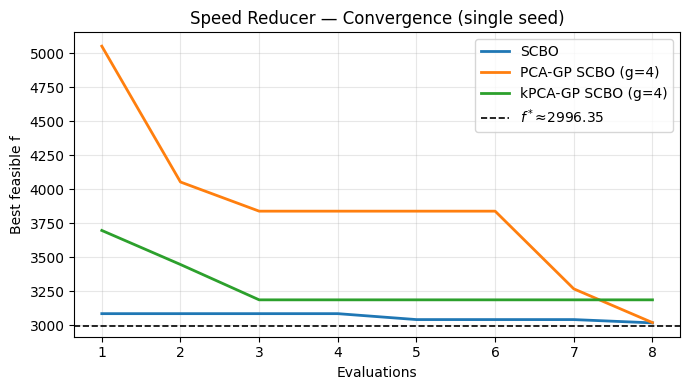

Final best (SCBO):      3017.814596022034
Final best (PCA-GP):    3019.8733602369143
Final best (kPCA-GP):   3187.2526491084714


In [ ]:
# Cell 7 — run SCBO vs PCA vs kPCA (single seed) and plot

seed = 12345  # <- change this to try different randomness
n_init = 20
iters = 100
n_cand = 4096
g_comp = 4  # PCA/kPCA components
gamma = 0.2  # kPCA RBF gamma

print("=== SCBO ===")
res_scbo = run_bo("scbo", seed=seed, n_init=n_init, iters=iters, n_cand=n_cand)

print("\n=== PCA-GP SCBO ===")
res_pca = run_bo("pca", seed=seed, n_init=n_init, iters=iters, n_cand=n_cand, n_components=g_comp)

print("\n=== kPCA-GP SCBO ===")
res_kpca = run_bo("kpca", seed=seed, n_init=n_init, iters=iters, n_cand=n_cand,
                  n_components=g_comp, kpca_gamma=gamma)


def plot_convergence(*pairs, f_star=2996.3482):
    plt.figure(figsize=(7, 4))
    for name, res in pairs:
        y = res["best_hist"]
        x = np.arange(1, len(y) + 1)
        m = ~np.isnan(y)
        plt.plot(x[m], y[m], lw=2, label=name)
    plt.axhline(f_star, ls="--", c="k", lw=1.2, label="$f^*$≈{:.2f}".format(f_star))
    plt.xlabel("Evaluations");
    plt.ylabel("Best feasible f")
    plt.title("Speed Reducer — Convergence (single seed)")
    plt.grid(True, alpha=0.3);
    plt.legend();
    plt.tight_layout();
    plt.show()


plot_convergence(
    ("SCBO", res_scbo),
    ("PCA-GP SCBO (g=4)", res_pca),
    ("kPCA-GP SCBO (g=4)", res_kpca),
    f_star=res_scbo["problem"].f_star_ref
)

print("Final best (SCBO):     ", np.nanmin(res_scbo["best_hist"]))
print("Final best (PCA-GP):   ", np.nanmin(res_pca["best_hist"]))
print("Final best (kPCA-GP):  ", np.nanmin(res_kpca["best_hist"]))
